In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns

import xgboost as xgb
import utils

In [2]:
color_pal = sns.color_palette()

In [3]:
Y_train_a = pd.read_parquet('../data/A/train_targets.parquet')
Y_train_b = pd.read_parquet('../data/B/train_targets.parquet')
Y_train_c = pd.read_parquet('../data/C/train_targets.parquet')
Y_train_a = Y_train_a.set_index('time')
Y_train_b = Y_train_b.set_index("time")
Y_train_c = Y_train_c.set_index("time")


In [4]:
X_train_estimated_a = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../data/C/X_train_estimated.parquet')
X_train_estimated_a = X_train_estimated_a.set_index("date_forecast")
X_train_estimated_b = X_train_estimated_b.set_index("date_forecast")
X_train_estimated_c = X_train_estimated_c.set_index("date_forecast")


In [5]:
X_train_observed_a = pd.read_parquet('../data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../data/C/X_train_observed.parquet')
X_train_observed_a = X_train_observed_a.set_index("date_forecast")
X_train_observed_b = X_train_observed_b.set_index("date_forecast")
X_train_observed_c = X_train_observed_c.set_index("date_forecast")


In [6]:
X_test_estimated_a = pd.read_parquet('../data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../data/C/X_test_estimated.parquet')
X_test_estimated_a = X_test_estimated_a.set_index("date_forecast")
X_test_estimated_b = X_test_estimated_b.set_index("date_forecast")
X_test_estimated_c = X_test_estimated_c.set_index("date_forecast")


In [7]:
X_train_observed_a.describe()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,118669.000000,118669.000000,96422.000000,1.186690e+05,118669.000000,110603.000000,118669.000000,118669.000000,118669.000000,1.186690e+05,...,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000
mean,6.652576,1.249064,2907.949219,5.994018e+05,166.500381,1737.142212,0.022398,276.823395,44.918282,1.617057e+05,...,179.629486,1.529545,0.059087,280.708557,74.401077,32446.992188,3.043197,0.756781,0.517437,0.000019
std,2.796349,0.036319,2570.413086,8.795423e+05,244.945358,1815.584106,0.190367,6.701763,64.786697,2.301970e+05,...,103.779366,24.146885,0.109496,6.573763,33.515800,17968.044922,1.779247,2.856113,1.851790,0.001392
min,0.700000,1.145000,27.799999,0.000000e+00,0.000000,27.900000,-1.000000,250.899994,0.000000,0.000000e+00,...,0.002000,-50.004002,0.000000,258.899994,0.000000,154.300003,0.000000,-7.300000,-9.300000,-0.000000
25%,4.400000,1.224000,1102.900024,0.000000e+00,0.000000,590.700012,0.000000,272.100006,0.000000,0.000000e+00,...,88.487999,-15.066000,0.000000,275.899994,54.799999,15592.400391,1.700000,-1.400000,-0.700000,0.000000
50%,6.300000,1.247000,1882.400024,3.574770e+04,8.600000,1162.599976,0.000000,277.200012,4.100000,2.481410e+04,...,179.436996,1.202000,0.000000,280.700012,93.699997,36359.800781,2.700000,0.400000,0.500000,0.000000
75%,8.600000,1.272000,3969.750000,1.037819e+06,288.799988,2079.600098,0.000000,282.000000,76.000000,2.743256e+05,...,270.640991,18.995001,0.100000,285.200012,99.900002,48084.500000,4.100000,2.700000,1.700000,0.000000
max,17.500000,1.427000,12328.500000,3.005720e+06,836.400024,11688.700195,1.000000,293.799988,345.700012,1.205498e+06,...,359.997986,49.999001,1.400000,303.299988,100.000000,71349.898438,15.200000,12.300000,8.600000,0.100000


In [8]:
X_train_observed_b.describe()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,116929.000000,116929.000000,98157.000000,1.169290e+05,116929.000000,109456.000000,116929.000000,116929.000000,116929.000000,1.169290e+05,...,116929.000000,116929.000000,116929.000000,116929.000000,116929.000000,116929.000000,116929.000000,116929.000000,116929.000000,116929.000000
mean,6.125604,1.254262,2651.450439,5.421514e+05,150.597580,1731.706665,0.008484,275.524536,40.894447,1.472200e+05,...,179.569458,-0.322831,0.059315,279.630524,73.500275,33040.113281,3.122094,0.750841,0.548524,0.000027
std,2.727944,0.035289,2404.853516,8.400522e+05,233.948273,1726.011108,0.117327,6.773766,61.530506,2.187106e+05,...,103.222916,24.058186,0.110211,6.634622,33.893852,18019.267578,1.827768,2.946939,1.881538,0.001654
min,0.700000,1.151000,27.799999,0.000000e+00,0.000000,27.900000,-1.000000,250.899994,0.000000,0.000000e+00,...,0.002000,-50.004002,0.000000,258.899994,0.000000,169.199997,0.000000,-7.300000,-9.300000,0.000000
25%,4.100000,1.230000,1037.900024,0.000000e+00,0.000000,648.799988,0.000000,271.100006,0.000000,0.000000e+00,...,89.507004,-17.388000,0.000000,275.000000,52.700001,16502.699219,1.700000,-1.500000,-0.700000,0.000000
50%,5.500000,1.254000,1732.300049,1.271020e+04,0.000000,1219.800049,0.000000,275.299988,0.000000,1.398140e+04,...,179.457001,-0.276000,0.000000,278.799988,92.599998,37614.101562,2.800000,0.400000,0.600000,0.000000
75%,8.000000,1.277000,3412.199951,8.693612e+05,242.000000,2074.100098,0.000000,280.799988,69.000000,2.484388e+05,...,269.739014,16.606001,0.100000,284.200012,99.900002,48268.601562,4.200000,2.700000,1.700000,0.000000
max,17.500000,1.426000,12328.799805,3.005700e+06,836.400024,11688.900391,1.000000,293.799988,345.700012,1.205341e+06,...,359.998993,49.998001,1.400000,303.299988,100.000000,70618.898438,15.200000,12.400000,8.600000,0.100000


In [9]:
X_train_observed_c.describe()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,116825.000000,116825.000000,96902.000000,1.168250e+05,116825.000000,108313.000000,116825.000000,116825.000000,116825.000000,1.168250e+05,...,116825.000000,116825.000000,116825.000000,116825.000000,116825.000000,116825.000000,116825.000000,116825.000000,116825.000000,116825.000000
mean,6.013866,1.253214,2605.747559,5.423583e+05,150.655075,1710.178467,-0.013867,275.147400,40.920612,1.473144e+05,...,179.576492,-0.334226,0.062269,279.682556,73.351135,33186.710938,2.855492,0.739988,0.838296,0.000211
std,2.789840,0.038392,2415.117920,8.404843e+05,234.069214,1751.569336,0.369077,7.103381,61.696342,2.192759e+05,...,103.210327,24.077934,0.114863,6.675199,34.580784,18169.167969,1.632607,2.418446,1.928824,0.011781
min,0.500000,1.139000,27.799999,0.000000e+00,0.000000,27.900000,-1.000000,247.300003,0.000000,0.000000e+00,...,0.003000,-50.042000,0.000000,257.899994,0.000000,130.600006,0.000000,-6.300000,-8.800000,-0.100000
25%,4.000000,1.228000,981.400024,0.000000e+00,0.000000,618.500000,0.000000,270.600006,0.000000,0.000000e+00,...,89.529999,-17.424999,0.000000,275.000000,52.599998,16388.000000,1.600000,-0.900000,-0.500000,0.000000
50%,5.400000,1.253000,1643.000000,1.267980e+04,0.000000,1178.400024,0.000000,274.899994,0.000000,1.394200e+04,...,179.462997,-0.288000,0.000000,278.899994,93.300003,37765.199219,2.500000,0.400000,0.900000,0.000000
75%,7.900000,1.277000,3406.175049,8.698632e+05,242.000000,2056.399902,0.000000,280.600006,68.900002,2.478511e+05,...,269.747009,16.603001,0.100000,284.299988,99.900002,48576.000000,3.800000,2.300000,2.000000,0.000000
max,18.900000,1.441000,12431.299805,3.007722e+06,837.000000,11665.700195,1.000000,295.100006,344.500000,1.217465e+06,...,359.998993,50.036999,1.400000,303.200012,100.000000,72215.000000,14.300000,11.400000,9.000000,0.100000


In [11]:
column_list = X_train_estimated_a.columns.to_list()
for column in column_list:
    print(column)

date_calc
absolute_humidity_2m:gm3
air_density_2m:kgm3
ceiling_height_agl:m
clear_sky_energy_1h:J
clear_sky_rad:W
cloud_base_agl:m
dew_or_rime:idx
dew_point_2m:K
diffuse_rad:W
diffuse_rad_1h:J
direct_rad:W
direct_rad_1h:J
effective_cloud_cover:p
elevation:m
fresh_snow_12h:cm
fresh_snow_1h:cm
fresh_snow_24h:cm
fresh_snow_3h:cm
fresh_snow_6h:cm
is_day:idx
is_in_shadow:idx
msl_pressure:hPa
precip_5min:mm
precip_type_5min:idx
pressure_100m:hPa
pressure_50m:hPa
prob_rime:p
rain_water:kgm2
relative_humidity_1000hPa:p
sfc_pressure:hPa
snow_density:kgm3
snow_depth:cm
snow_drift:idx
snow_melt_10min:mm
snow_water:kgm2
sun_azimuth:d
sun_elevation:d
super_cooled_liquid_water:kgm2
t_1000hPa:K
total_cloud_cover:p
visibility:m
wind_speed_10m:ms
wind_speed_u_10m:ms
wind_speed_v_10m:ms
wind_speed_w_1000hPa:ms


In [16]:
# Notice that missing rows are simply non-existent, not filled with NaN or anything
# From 21. october
display(Y_train_a[29660:29670])

,pv_measurement
time,
2022-10-20 18:00:00,0.0
2022-10-20 19:00:00,0.0
2022-10-20 20:00:00,0.0
2022-10-20 21:00:00,0.0
2022-10-20 22:00:00,0.0
2022-10-20 23:00:00,0.0
2022-10-21 00:00:00,0.0
2022-10-28 22:00:00,0.0
2022-10-28 23:00:00,0.0


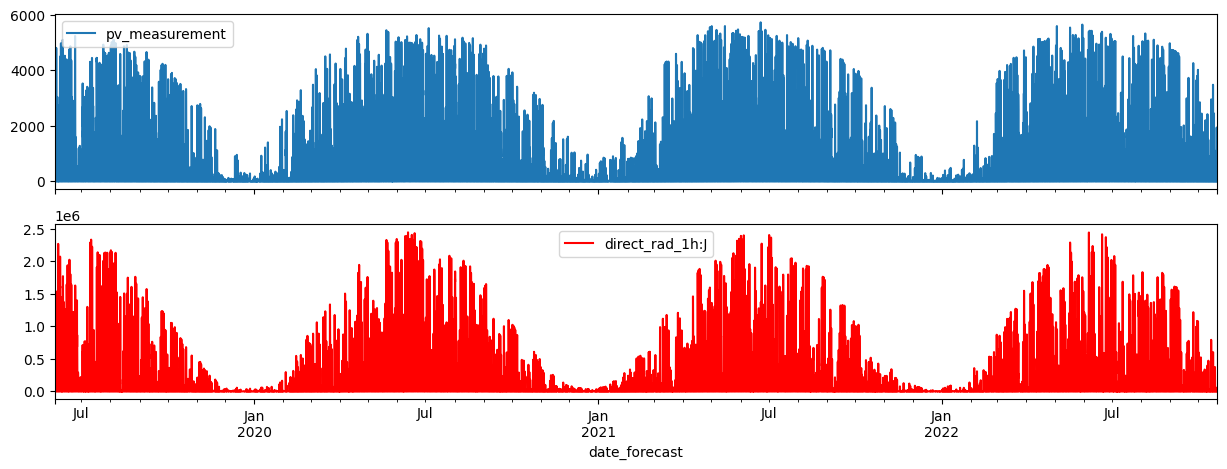

In [23]:
# Hardcoded plotting

# Specify the date range
start_date = '2019-06-02 22:00:00'
end_date = '2024'

feature_name = "direct_rad_1h:J"

# Subset the data based on the date range and plot the 'pv_measurement' column
fig, axs = plt.subplots(2, 1, figsize=(15,5), sharex=True)
Y_train_a[(Y_train_a.index >= start_date) & (Y_train_a.index <= end_date)].resample("H").mean().plot(ax=axs[0])
X_train_observed_a[(X_train_observed_a.index >= start_date) & (X_train_observed_a.index <= end_date)].resample(
    "H").mean()[feature_name].plot(ax=axs[1], label=feature_name, color="red")

axs[0].legend()
axs[1].legend()

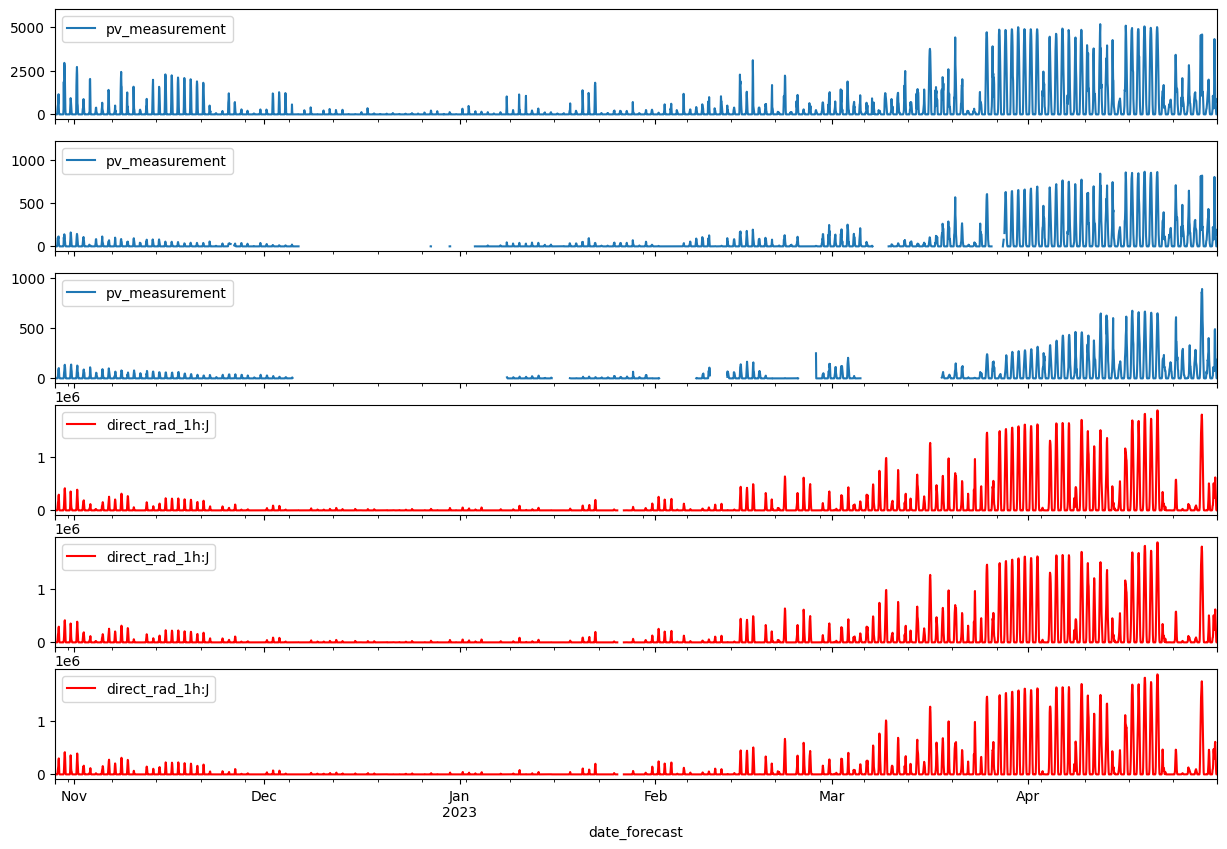

In [25]:
# generalized plotting
start_date = '2019'
end_date = '2024'

feature_name = "direct_rad_1h:J"

Y = [Y_train_a, Y_train_b, Y_train_c]
X = [X_train_estimated_a, X_train_estimated_b, X_train_estimated_c]

utils.plot_ts(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

In [26]:

# first, take the mean of every hour in the X value dataset, to match the resolution of the y-values.
for i in range(0, len(X_train_estimated_a), 4):
    if i + 4 <= len(X_train_estimated_a):
        mean_values = X_train_estimated_a.iloc[i:i+4].mean()
        X_train_estimated_a.iloc[i] = mean_values

display(X_train_estimated_a.head())


    
# join the y values into x-dataframes for training
train_a = pd.merge(X_train_estimated_a, Y_train_a, left_index=True, right_index=True)
display(train_a.head())

,date_calc,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
date_forecast,,,,,,,,,,,,,,,,,,,,,
2022-10-28 22:00:00,2022-10-27 07:00:18,8.349999,1.233,2416.250000,0.0,0.0,1734.949951,1.0,281.274994,0.0,...,347.822754,-39.065247,0.0,284.675018,100.0,20712.523438,0.700,-0.325,0.650,0.0
2022-10-28 22:15:00,2022-10-27 07:00:18,8.400000,1.233,2085.899902,0.0,0.0,1560.500000,1.0,281.299988,0.0,...,345.451996,-38.955002,0.0,284.700012,100.0,23604.099609,0.700,-0.400,0.700,-0.0
2022-10-28 22:30:00,2022-10-27 07:00:18,8.300000,1.233,2746.600098,0.0,0.0,1909.400024,1.0,281.200012,0.0,...,350.153015,-39.310001,0.0,284.700012,100.0,17799.800781,0.700,-0.300,0.600,-0.0
2022-10-28 22:45:00,2022-10-27 07:00:18,8.300000,1.233,3407.399902,0.0,0.0,2258.199951,1.0,281.200012,0.0,...,354.886993,-39.528999,0.0,284.600006,100.0,12016.500000,0.600,-0.200,0.600,-0.0
2022-10-28 23:00:00,2022-10-27 07:00:18,8.100000,1.234,4035.199951,0.0,0.0,2059.875000,1.0,280.850006,0.0,...,96.748245,-39.382252,0.0,284.325012,100.0,5624.174805,0.775,0.425,0.525,0.0


,date_calc,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,pv_measurement
2022-10-28 22:00:00,2022-10-27 07:00:18,8.349999,1.23300,2416.250000,0.0,0.0,1734.949951,1.0,281.274994,0.0,...,-39.065247,0.00,284.675018,100.0,20712.523438,0.700,-0.325,0.650,0.0,0.0
2022-10-28 23:00:00,2022-10-27 07:00:18,8.100000,1.23400,4035.199951,0.0,0.0,2059.875000,1.0,280.850006,0.0,...,-39.382252,0.00,284.325012,100.0,5624.174805,0.775,0.425,0.525,0.0,0.0
2022-10-29 00:00:00,2022-10-28 07:00:05,8.150000,1.22975,1882.000000,0.0,0.0,1675.050049,1.0,280.925018,0.0,...,-38.040501,0.20,283.875000,100.0,3240.425049,1.500,1.050,0.975,0.0,0.0
2022-10-29 01:00:00,2022-10-28 07:00:05,8.200000,1.22850,1622.399902,0.0,0.0,1547.550049,1.0,281.049988,0.0,...,-34.390503,0.25,284.350006,100.0,3243.500000,1.575,1.000,1.200,0.0,0.0
2022-10-29 02:00:00,2022-10-28 07:00:05,8.375000,1.22700,1322.275024,0.0,0.0,1053.724976,1.0,281.350006,0.0,...,-29.268749,0.25,284.524994,100.0,2528.450195,2.200,1.825,1.175,0.0,0.0
